Loading manifest from ../data/d2_manifest_t2fs.csv and creating slice map...
Slice map created. Found 582 slices containing the uterus.
Loading manifest from ../data/d2_manifest_t2fs.csv and creating slice map...
Slice map created. Found 582 slices containing the uterus.
Data successfully split:
Training patients: 48, Validation patients: 12
Training slices: 450
Validation slices: 132

Using device: cuda

--- Starting Baseline Model Training with Augmentation ---


Validation: 100%|██████████| 132/132 [00:20<00:00,  6.30it/s]


Epoch 1/20 -> Train Loss: 0.5767, Val Loss: 0.4750, Val Dice: 0.5894


Validation: 100%|██████████| 132/132 [00:19<00:00,  6.64it/s]


Epoch 2/20 -> Train Loss: 0.4293, Val Loss: 0.4146, Val Dice: 0.5668


Validation: 100%|██████████| 132/132 [00:21<00:00,  6.15it/s]


Epoch 3/20 -> Train Loss: 0.3235, Val Loss: 0.3517, Val Dice: 0.5295


Validation: 100%|██████████| 132/132 [00:21<00:00,  6.03it/s]


Epoch 4/20 -> Train Loss: 0.2543, Val Loss: 0.3029, Val Dice: 0.6029


Validation: 100%|██████████| 132/132 [00:21<00:00,  6.10it/s]


Epoch 5/20 -> Train Loss: 0.2269, Val Loss: 0.2937, Val Dice: 0.5605


Validation: 100%|██████████| 132/132 [00:20<00:00,  6.30it/s]


Epoch 6/20 -> Train Loss: 0.1947, Val Loss: 0.2974, Val Dice: 0.5369


Validation: 100%|██████████| 132/132 [00:20<00:00,  6.31it/s]


Epoch 7/20 -> Train Loss: 0.1876, Val Loss: 0.3146, Val Dice: 0.4761


Validation: 100%|██████████| 132/132 [00:20<00:00,  6.34it/s]


Epoch 8/20 -> Train Loss: 0.1812, Val Loss: 0.3814, Val Dice: 0.4005


Validation: 100%|██████████| 132/132 [00:21<00:00,  6.25it/s]


Epoch 9/20 -> Train Loss: 0.1807, Val Loss: 0.3406, Val Dice: 0.4630


Validation: 100%|██████████| 132/132 [00:21<00:00,  6.20it/s]


Epoch 10/20 -> Train Loss: 0.1681, Val Loss: 0.4477, Val Dice: 0.2527


Validation: 100%|██████████| 132/132 [00:24<00:00,  5.44it/s]


Epoch 11/20 -> Train Loss: 0.1680, Val Loss: 0.3291, Val Dice: 0.4688


Validation: 100%|██████████| 132/132 [00:24<00:00,  5.38it/s]


Epoch 12/20 -> Train Loss: 0.1628, Val Loss: 0.3687, Val Dice: 0.3947


Validation: 100%|██████████| 132/132 [00:22<00:00,  5.86it/s]


Epoch 13/20 -> Train Loss: 0.1701, Val Loss: 0.3216, Val Dice: 0.4836


Validation: 100%|██████████| 132/132 [00:23<00:00,  5.59it/s]


Epoch 14/20 -> Train Loss: 0.1583, Val Loss: 0.2653, Val Dice: 0.5696


Validation: 100%|██████████| 132/132 [00:23<00:00,  5.52it/s]


Epoch 15/20 -> Train Loss: 0.1515, Val Loss: 0.2404, Val Dice: 0.6170


Validation: 100%|██████████| 132/132 [00:23<00:00,  5.63it/s]


Epoch 16/20 -> Train Loss: 0.1521, Val Loss: 0.5032, Val Dice: 0.2453


Validation: 100%|██████████| 132/132 [00:23<00:00,  5.57it/s]


Epoch 17/20 -> Train Loss: 0.1501, Val Loss: 0.2480, Val Dice: 0.6065


Validation: 100%|██████████| 132/132 [00:23<00:00,  5.56it/s]


Epoch 18/20 -> Train Loss: 0.1432, Val Loss: 0.2909, Val Dice: 0.5320


Validation: 100%|██████████| 132/132 [00:23<00:00,  5.58it/s]


Epoch 19/20 -> Train Loss: 0.1453, Val Loss: 0.3028, Val Dice: 0.5527


Validation: 100%|██████████| 132/132 [00:23<00:00,  5.59it/s]


Epoch 20/20 -> Train Loss: 0.1367, Val Loss: 0.3627, Val Dice: 0.4151
--- Finished Training ---


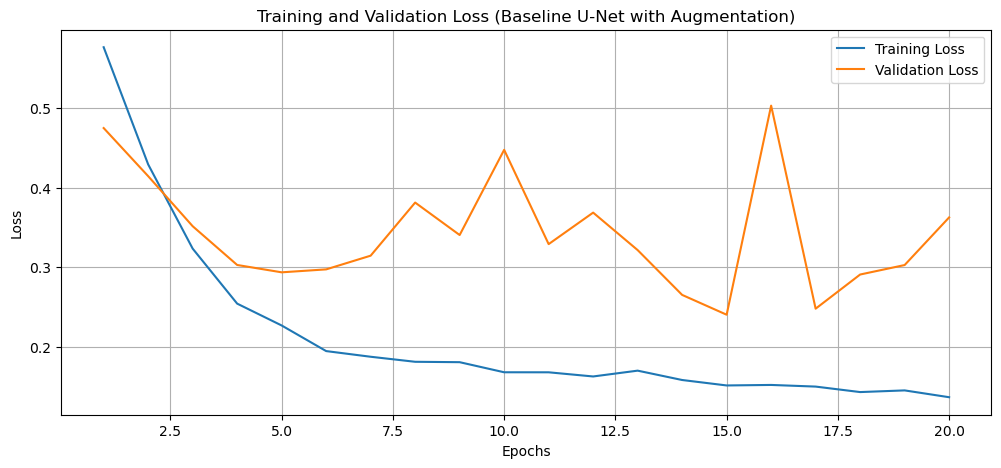

In [2]:
# --- Imports ---
import sys
import os
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import SimpleITK as sitk

from src.data_loader import UterusDataset
from src.models import UNet

# --- Configuration ---
manifest_path = '../data/d2_manifest_t2fs.csv'
image_size = 256
batch_size = 1 # Using batch size of 1 as recommended
num_epochs = 20
lr = 1e-4

# --- Data Loading with Augmentation ---
train_full_dataset = UterusDataset(manifest_path=manifest_path, image_size=image_size, augment=True)
val_full_dataset = UterusDataset(manifest_path=manifest_path, image_size=image_size, augment=False)

usable_patient_ids = train_full_dataset.manifest['patient_id'].unique()
split_idx = int(len(usable_patient_ids) * 0.8)
train_ids, val_ids = usable_patient_ids[:split_idx], usable_patient_ids[split_idx:]

train_indices = [i for i, sm in enumerate(train_full_dataset.slice_map) if train_full_dataset.manifest.loc[sm['patient_index'], 'patient_id'] in train_ids]
val_indices = [i for i, sm in enumerate(val_full_dataset.slice_map) if val_full_dataset.manifest.loc[sm['patient_index'], 'patient_id'] in val_ids]

train_dataset = Subset(train_full_dataset, train_indices)
val_dataset = Subset(val_full_dataset, val_indices)

# Using num_workers=1 as a stable compromise
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
print(f"Data successfully split:\nTraining patients: {len(train_ids)}, Validation patients: {len(val_ids)}\nTraining slices: {len(train_dataset)}\nValidation slices: {len(val_dataset)}")

# --- Metrics, Loss, and Training Functions ---
def dice_score(preds, targets, epsilon=1e-6):
    preds_flat = preds.view(-1); targets_flat = targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    return (2. * intersection + epsilon) / (preds_flat.sum() + targets_flat.sum() + epsilon)

class DiceBCELoss(nn.Module):
    def __init__(self, weight=0.5): super(DiceBCELoss, self).__init__(); self.weight = weight
    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs); inputs_flat = inputs.view(-1); targets_flat = targets.view(-1)
        bce = F.binary_cross_entropy(inputs_flat, targets_flat, reduction='mean')
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs_flat.sum() + targets_flat.sum() + smooth)
        return bce * self.weight + dice_loss * (1 - self.weight)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train(); running_loss = 0.0
    for images, masks in tqdm(loader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad(); outputs = model(images); loss = criterion(outputs, masks); loss.backward(); optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def validate(model, loader, criterion, device):
    model.eval(); running_loss = 0.0; running_dice = 0.0
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images); loss = criterion(outputs, masks)
            preds = torch.sigmoid(outputs) > 0.5; dice = dice_score(preds, masks)
            running_loss += loss.item() * images.size(0); running_dice += dice.item() * images.size(0)
    return running_loss / len(loader.dataset), running_dice / len(loader.dataset)

# --- Main Training Loop ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print(f"\nUsing device: {device}")

baseline_model_aug = UNet(n_channels=1, n_classes=1).to(device)
optimizer = Adam(baseline_model_aug.parameters(), lr=lr)
criterion = DiceBCELoss()

train_loss_history, val_loss_history, val_dice_history = [], [], []

print("\n--- Starting Baseline Model Training with Augmentation ---")
for epoch in range(num_epochs):
    train_loss = train_one_epoch(baseline_model_aug, train_loader, optimizer, criterion, device)
    val_loss, val_dice = validate(baseline_model_aug, val_loader, criterion, device)
    train_loss_history.append(train_loss); val_loss_history.append(val_loss); val_dice_history.append(val_dice)
    print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")
print("--- Finished Training ---")

# --- Visualization ---
plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss (Baseline U-Net with Augmentation)')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True); plt.show()

Loading manifest from ../data/d2_manifest_t2fs.csv and creating slice map...
Slice map created. Found 582 slices containing the uterus.
Loading manifest from ../data/d2_manifest_t2fs.csv and creating slice map...
Slice map created. Found 582 slices containing the uterus.


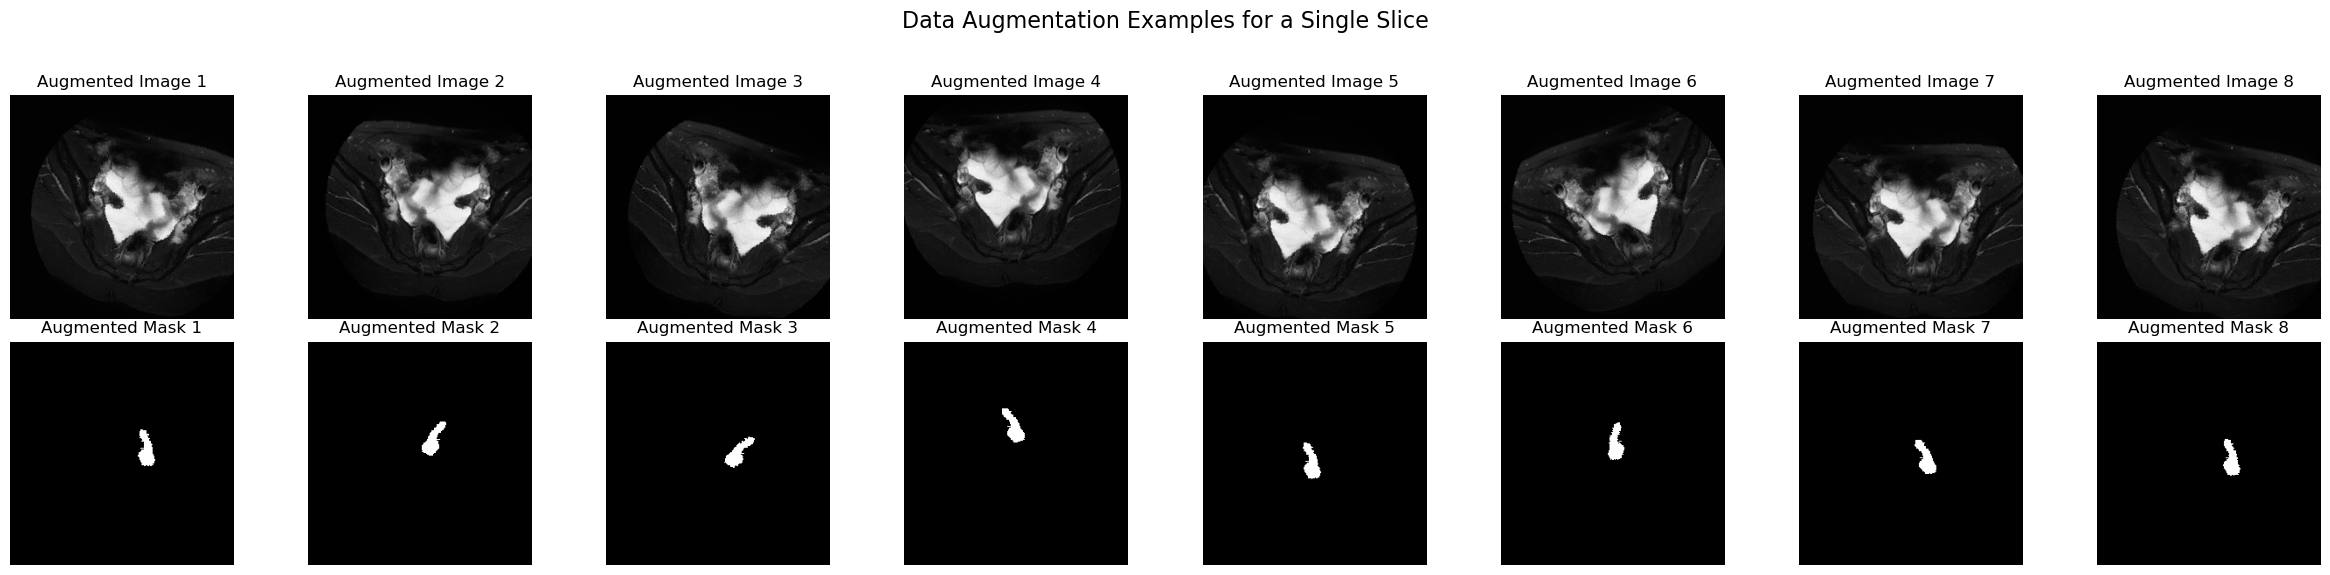

In [3]:
# --- Visualize Data Augmentation ---

# We only need the training dataset instance for this
train_dataset_for_viz = UterusDataset(manifest_path=manifest_path, image_size=image_size, augment=True)

# Let's grab a single, clean sample to augment
# We'll get it from the validation set object which doesn't apply augmentation by default
val_dataset_for_viz = UterusDataset(manifest_path=manifest_path, image_size=image_size, augment=False)
sample_idx_for_viz = 100 # You can change this index to see a different slice
original_image, original_mask = val_dataset_for_viz[sample_idx_for_viz]

# Now, let's apply the augmentation transform to this single sample 8 times
num_augmentations = 8
fig, axes = plt.subplots(2, num_augmentations, figsize=(24, 6))
plt.suptitle("Data Augmentation Examples for a Single Slice", fontsize=16)

for i in range(num_augmentations):
    # Get the augmented sample by calling __getitem__ on the training dataset instance
    # Note: We are using the same index, but the augmentation is random each time
    aug_image, aug_mask = train_dataset_for_viz[sample_idx_for_viz]
    
    # Plot the augmented image
    axes[0, i].imshow(aug_image.squeeze(), cmap='gray')
    axes[0, i].set_title(f"Augmented Image {i+1}")
    axes[0, i].axis('off')
    
    # Plot the augmented mask
    axes[1, i].imshow(aug_mask.squeeze(), cmap='gray')
    axes[1, i].set_title(f"Augmented Mask {i+1}")
    axes[1, i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()